**Task 2**

**Question 1**

Image Reconstruction - Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates (X,Y) to the pixel colors (R,G,B). Here, (X,Y) represents the coordinates of the pixels, and (R,G,B) represents the color values at those coordinates. Display both the original image and the reconstructed image. Also, calculate and report the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [4]:
if os.path.exists('Ml_2r.jpg'):
    print('ML_2.jpg exists')
else:
    !wget https://www.google.com/url?sa=i&url=https%3A%2F%2Fwallpapers.com%2Fnice-pictures&psig=AOvVaw0zpc93MrmY5UXbdX3GJfvn&ust=1726132989238000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCPi1jdDIuogDFQAAAAAdAAAAABAc

ML_2.jpg exists


In [5]:
img = torchvision.io.read_image("Ml_2r.jpg")
print(img.shape)

torch.Size([3, 280, 455])


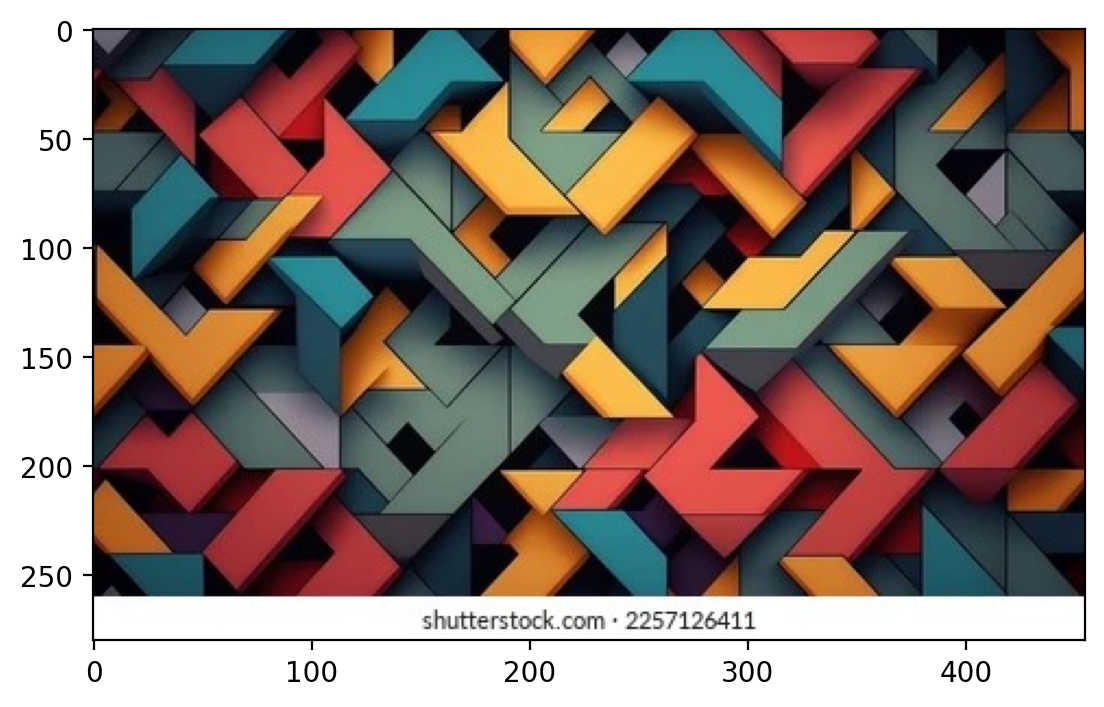

In [6]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [7]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [9]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [10]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.4353, 0.4157, 0.3922,  ..., 0.4118, 0.4157, 0.4275],
         [0.4000, 0.4196, 0.4157,  ..., 0.4196, 0.4235, 0.4353],
         [0.4275, 0.3765, 0.4235,  ..., 0.4314, 0.4353, 0.4471],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.4118, 0.3922, 0.3765,  ..., 0.1294, 0.1333, 0.1373],
         [0.3765, 0.3961, 0.4000,  ..., 0.1373, 0.1451, 0.1451],
         [0.4118, 0.3608, 0.4078,  ..., 0.1529, 0.1569, 0.1608],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.4667, 0.4471, 0.4314,  ..., 0.0353, 0.0353, 0.0314],
         [0.4314, 0.4510, 0.4549,  ..., 0.0392, 0.0353, 0.0392],
         [0.4667, 0.4157, 0.4627,  ..., 0.0353, 0.0314, 0.

In [14]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 0, 0, 250, 300)
crop.shape

torch.Size([3, 250, 300])

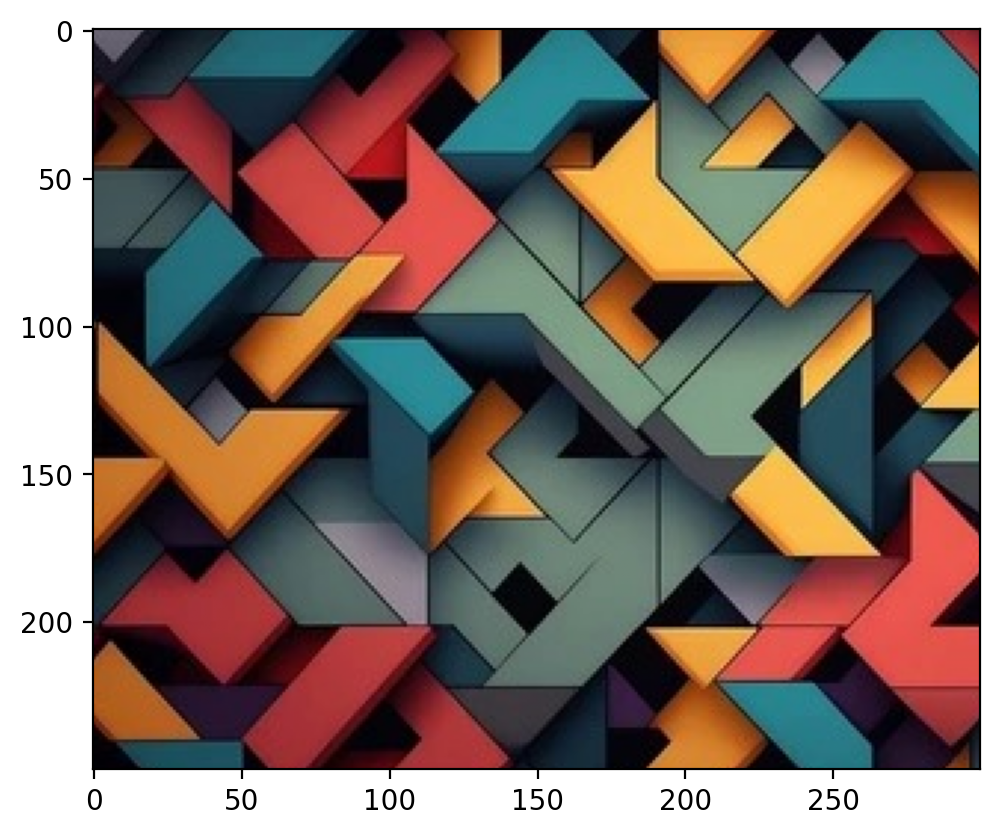

In [15]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [16]:
crop = crop.to(device)

In [17]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 250 300


In [18]:
num_channels, height, width = 2, 3, 4

    
# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [19]:
X.shape

torch.Size([12, 2])

In [42]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [43]:
img_X, img_Y = create_coordinate_map(crop)

img_X.shape, img_Y.shape

(torch.Size([75000, 2]), torch.Size([75000, 3]))

In [44]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())

# Scale the X coordinates
img_X_scaled = scaler_X.transform(img_X.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled = torch.tensor(img_X_scaled).to(device)

# Set to dtype float32
img_X_scaled = img_X_scaled.float()

In [45]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [46]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [47]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [48]:
train(net, 0.01, img_X_scaled, img_Y, 1000)

Epoch 0 loss: 0.317277
Epoch 100 loss: 0.052528
Epoch 200 loss: 0.052052
Epoch 300 loss: 0.052052
Epoch 400 loss: 0.052052
Epoch 500 loss: 0.052052
Epoch 600 loss: 0.052052
Epoch 700 loss: 0.052052
Epoch 800 loss: 0.052052
Epoch 900 loss: 0.052052


0.05205230042338371

In [37]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    num_channels, height, width = original_img.shape
    net.eval()
    
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)  # Ensure the shape is (height, width, num_channels)

    # Convert to NumPy arrays
    reconstructed_img_np = outputs.cpu().numpy()  # Shape should be (height, width, num_channels)
    original_img_np = original_img.cpu().permute(1, 2, 0).numpy()  # Shape: (height, width, num_channels)

    # Plotting
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(reconstructed_img_np)
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img_np)
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()

    return original_img_np, reconstructed_img_np  # Return NumPy arrays for metric calculations

def compute_rmse(original_img, predicted_img):
    return np.sqrt(mean_squared_error(original_img.flatten(), predicted_img.flatten()))

def compute_psnr(original_img, predicted_img):
    mse = np.mean((original_img - predicted_img) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # Assuming pixel values are normalized between 0 and 1
    return 20 * math.log10(max_pixel / math.sqrt(mse))




RMSE: 0.2281497220678146
PSNR: 12.835601118978104


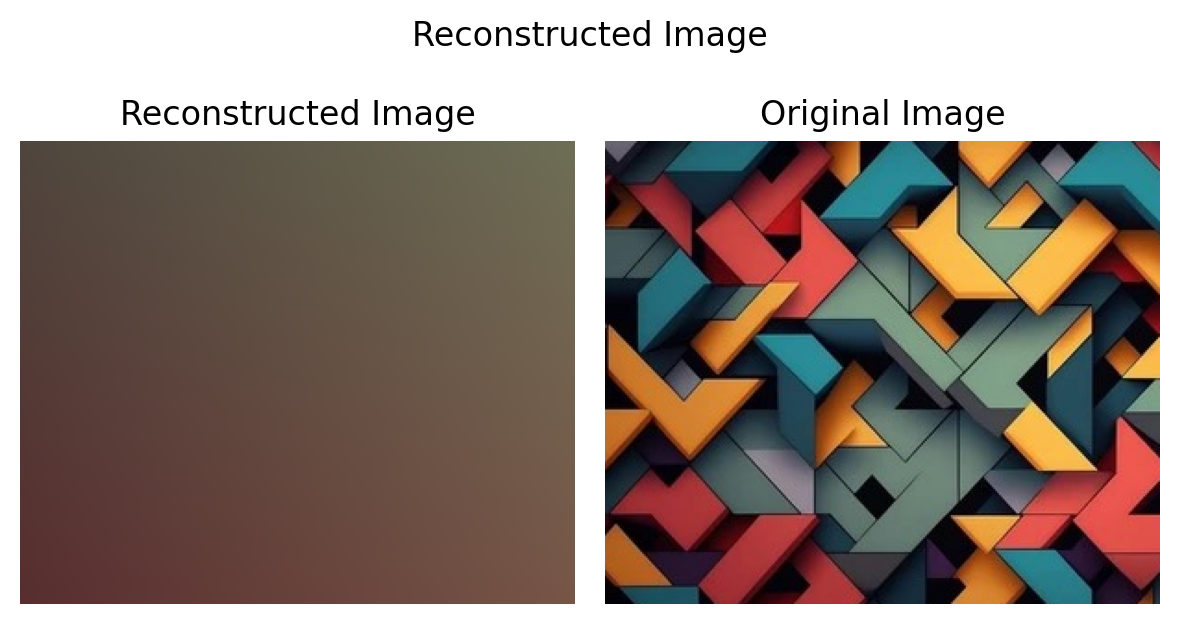

In [49]:
# Now, you can call the plotting function and compute metrics:
original_np, reconstructed_np = plot_reconstructed_and_original_image(crop, net, img_X_scaled, title="Reconstructed Image")

# Compute RMSE and PSNR
rmse = compute_rmse(original_np, reconstructed_np)
psnr_value = compute_psnr(original_np, reconstructed_np)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr_value}")

In [28]:
# Use polynomial features of degree "d"

def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int
    
    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]
    X2 = X[:, 1]
    X1 = X1.unsqueeze(1)
    X2 = X2.unsqueeze(1)
    X = torch.cat([X1, X2], dim=1)
    poly = preprocessing.PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())
    return torch.tensor(X, dtype=torch.float32).to(device)

In [29]:
img_X_scaled_poly = poly_features(img_X_scaled, 50)

In [30]:
img_X_scaled_poly.dtype, img_X_scaled_poly.shape, img_Y.shape, img_Y.dtype

(torch.float32,
 torch.Size([75000, 1326]),
 torch.Size([75000, 3]),
 torch.float32)

In [31]:
net = LinearModel(img_X_scaled_poly.shape[1], 3)
net.to(device)

train(net, 0.005, img_X_scaled_poly, img_Y, 1500)

Epoch 0 loss: 0.157450
Epoch 100 loss: 0.044509
Epoch 200 loss: 0.042498
Epoch 300 loss: 0.041478
Epoch 400 loss: 0.040808
Epoch 500 loss: 0.040325
Epoch 600 loss: 0.039920
Epoch 700 loss: 0.039594
Epoch 800 loss: 0.039311
Epoch 900 loss: 0.039065
Epoch 1000 loss: 0.038839
Epoch 1100 loss: 0.038637
Epoch 1200 loss: 0.038455
Epoch 1300 loss: 0.038290
Epoch 1400 loss: 0.038141


0.03801370784640312

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24277306..1.0846834].


RMSE: 0.1949750479726172
PSNR: 14.200419282614261


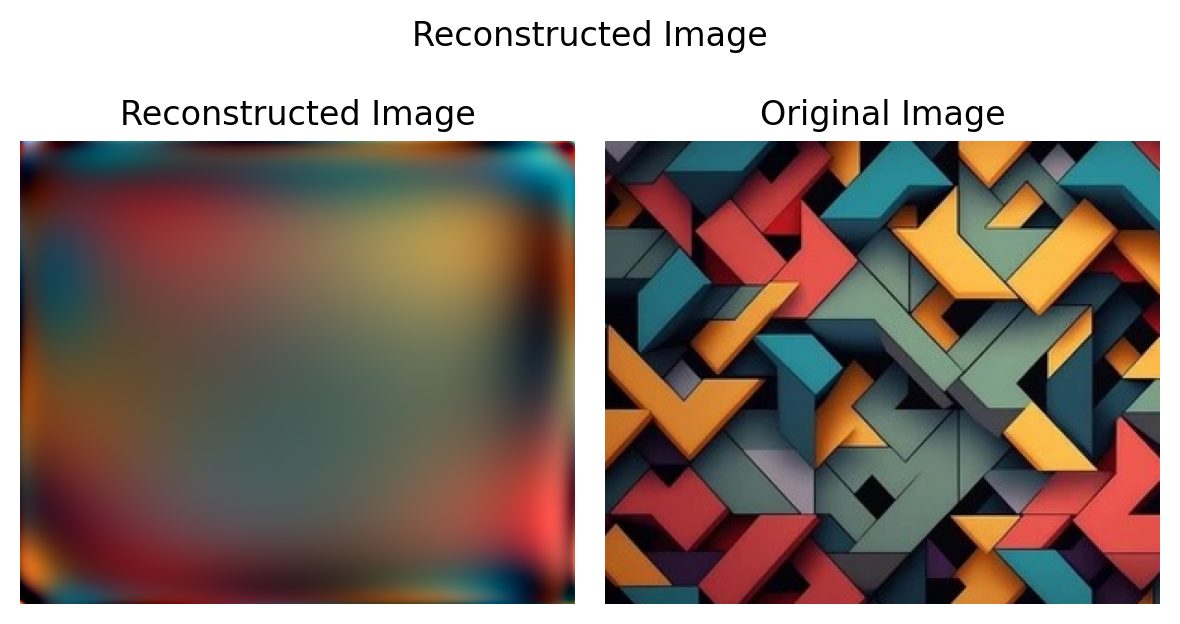

In [32]:
original_np, reconstructed_np = plot_reconstructed_and_original_image(crop, net, img_X_scaled_poly, title="Reconstructed Image")

# Compute RMSE and PSNR
rmse = compute_rmse(original_np, reconstructed_np)
psnr_value = compute_psnr(original_np, reconstructed_np)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr_value}")

In [12]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [38]:
X_rff = create_rff_features(img_X_scaled, 2000, 0.008)

In [39]:
X_rff.shape

torch.Size([75000, 2000])

In [40]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, img_Y, 1500)

Epoch 0 loss: 0.160713
Epoch 100 loss: 0.048581
Epoch 200 loss: 0.047117
Epoch 300 loss: 0.046852
Epoch 400 loss: 0.046749
Epoch 500 loss: 0.046707
Epoch 600 loss: 0.046689
Epoch 700 loss: 0.046682
Epoch 800 loss: 0.046679
Epoch 900 loss: 0.046678
Epoch 1000 loss: 0.046678
Epoch 1100 loss: 0.046678
Epoch 1200 loss: 0.046678
Epoch 1300 loss: 0.046678
Epoch 1400 loss: 0.046678


0.04667803645133972

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0004307106..0.798782].


RMSE: 0.21605100757475815
PSNR: 13.308874079474627


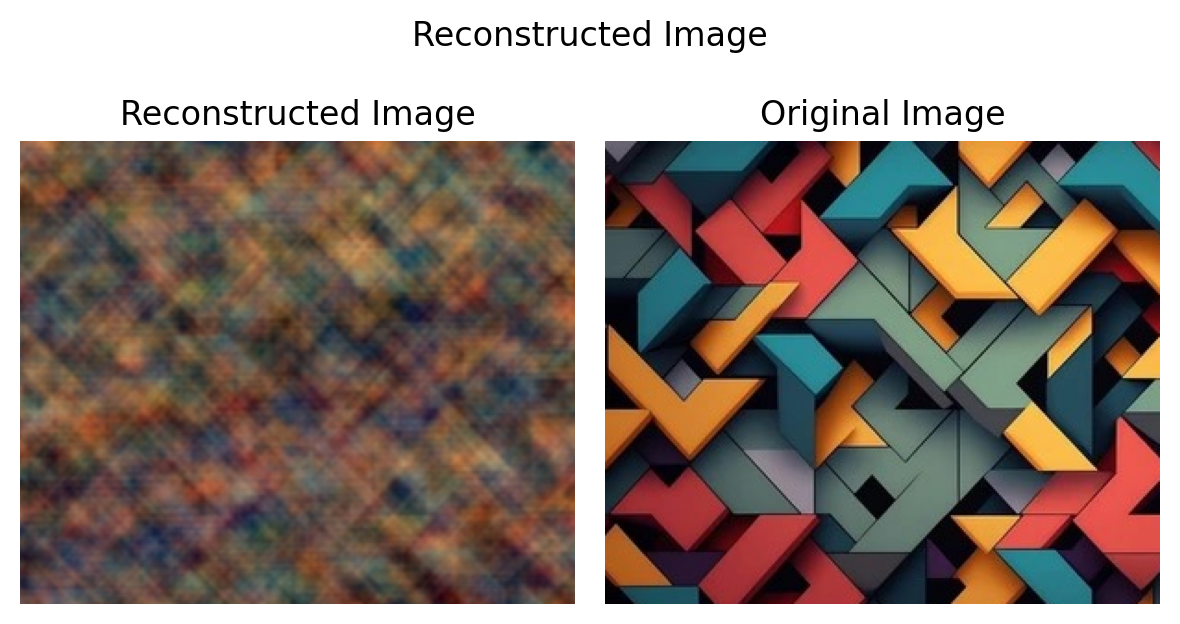

In [41]:
original_np, reconstructed_np = plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image")

# Compute RMSE and PSNR
rmse = compute_rmse(original_np, reconstructed_np)
psnr_value = compute_psnr(original_np, reconstructed_np)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr_value}")